In [1]:
#!pip install imblearn
import warnings
warnings.filterwarnings('ignore')

In [2]:
from pymongo import MongoClient
import pandas as pd

import numpy as np
from scipy import interp
from scipy.stats import ttest_1samp, wilcoxon, mannwhitneyu

import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.utils.fixes import signature

from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import ClusterCentroids, NearMiss
from imblearn.metrics import classification_report_imbalanced
############


In [3]:
NCU_fc=pd.read_csv('data/NCU_fc.csv')  
NCU_fc = NCU_fc.drop(['username'], axis=1)

In [4]:
datasets = 'NCU_fc'

In [5]:
NCU_fc['class'] = NCU_fc['score'] < 60
NCU_fc = NCU_fc.drop(['score'], axis=1)

In [6]:
NCU_fc

,active_num_days,active_sum_count,problem_num_days,problem_avg_count,problem_sum_count,video_num_days,video_sum_count,num_watched,seek_video_sum,pause_video_sum,...,video_stop_sum,video_play_sum,video_events_sum,mt_practice_sum,mt_unit_sum,mt_online_num_day,mt_online_practice_num_day,hw_mean,qz_mean,class
0,1.555556,328.055556,0.888889,7.064815,15.722222,1.166667,28.111111,7.055556,1.888889,3.611111,...,6.944444,22.222222,47.444444,0.000000,0.000000,0.000000,0.000000,9.900000,7.000000,False
1,0.333333,1.722222,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,True
2,2.166667,465.166667,0.722222,11.259259,14.833333,1.388889,220.500000,4.944444,2.777778,3.888889,...,1.444444,33.388889,68.666667,0.000000,0.000000,0.000000,0.000000,9.488889,7.777778,True
3,1.944444,262.500000,0.500000,5.305556,7.777778,1.111111,32.944444,5.055556,3.055556,3.277778,...,3.055556,22.055556,44.666667,1.777778,0.833333,0.555556,0.888889,9.555556,8.333333,True
4,1.611111,248.111111,0.500000,4.833333,11.666667,1.166667,30.555556,5.055556,3.000000,4.055556,...,1.888889,18.444444,36.222222,2.166667,1.277778,0.833333,1.500000,9.588889,6.722222,False
5,2.000000,338.055556,0.444444,4.944444,10.500000,1.277778,73.833333,3.944444,2.833333,3.000000,...,2.833333,49.500000,102.000000,2.222222,1.166667,0.833333,1.166667,9.522222,6.555556,True
6,1.611111,287.555556,0.722222,11.916667,19.444444,0.722222,39.666667,2.611111,1.666667,2.222222,...,1.166667,18.611111,38.388889,5.555556,1.611111,1.055556,1.888889,9.766667,8.333333,False
7,1.500000,174.888889,0.111111,2.361111,4.722222,0.722222,28.055556,2.388889,1.611111,2.222222,...,1.000000,19.000000,38.722222,3.666667,1.166667,1.000000,1.500000,9.811111,6.333333,False
8,2.333333,594.388889,0.944444,4.927778,16.333333,1.888889,108.888889,7.611111,3.666667,5.722222,...,4.000000,71.111111,146.333333,2.777778,1.388889,1.111111,1.666667,9.666667,9.777778,False
9,1.777778,163.722222,0.055556,4.611111,4.611111,1.222222,16.555556,5.000000,1.111111,2.888889,...,4.611111,13.944444,29.277778,2.277778,0.944444,0.555556,1.000000,9.877778,9.055556,False


In [7]:
X = NCU_fc.drop(['class'], axis=1)
X = X.values
y = NCU_fc['class']

# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)

clf_binary = svm.SVC(kernel='rbf', 
                     probability=True,
                     cache_size=700,
                     random_state=5)

clf_one = svm.OneClassSVM(kernel="rbf",
                         cache_size=700,
                        random_state=5)

In [8]:


def compute_roc (X, y, title):
    
    tprs = []
    aucs = []
    #acc = []
    mean_fpr = np.linspace(0, 1, 100)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    #fig, ax1 = plt.su
    
    i = 0
    for train, test in cv.split(X, y):

        y_pred = clf_binary.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], y_pred[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        acc = accuracy_score(y[test], y_pred[:, 1].round())
        precision, recall, _ = precision_recall_curve(y[test], y_pred[:, 1])
        average_precision = average_precision_score(y[test], y_pred[:, 1])
        #accs.append(accuracy_score(y[test], y_pred[:, 1].round()))
        ax1.plot(fpr, tpr, lw=1, alpha=0.3,
                 label='ROC fold %d (AUC = %0.2f, ACC = %0.2f)' % (i, roc_auc, acc))

        i += 1
    ax1.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
             label='Chance', alpha=.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax1.plot(mean_fpr, mean_tpr, color='b',
             label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
             lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax1.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax1.set_xlim([-0.05, 1.05])
    ax1.set_ylim([-0.05, 1.05])
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('Receiver operating characteristic of '+ title)
    ax1.legend(loc="lower right")
    
    
    # In matplotlib < 1.5, plt.fill_between does not have a 'step' argument
    step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
    ax2.step(recall, precision, color='b', alpha=0.2, where='post')
    ax2.fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_ylim([0.0, 1.05])
    ax2.set_xlim([0.0, 1.0])
    ax2.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
    
    image_name = './images/' + datasets + '_' + title + '.png'
    fig.savefig(image_name, dpi=300)
    
    return aucs


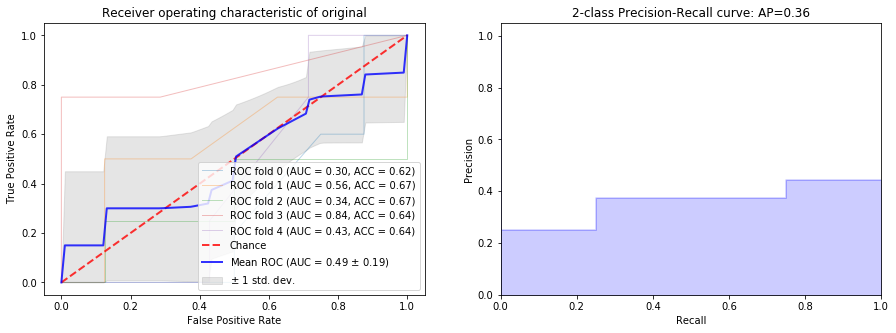

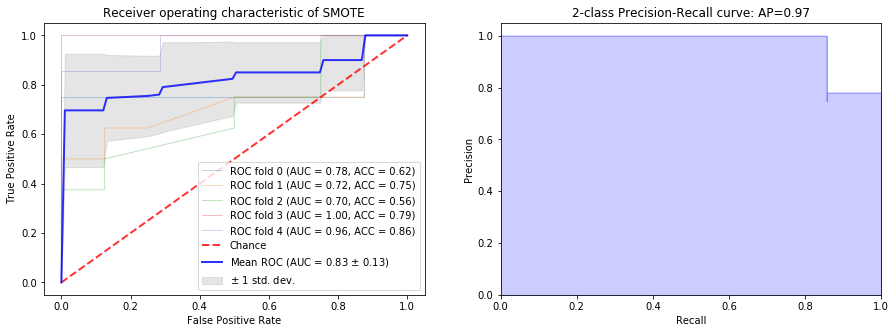

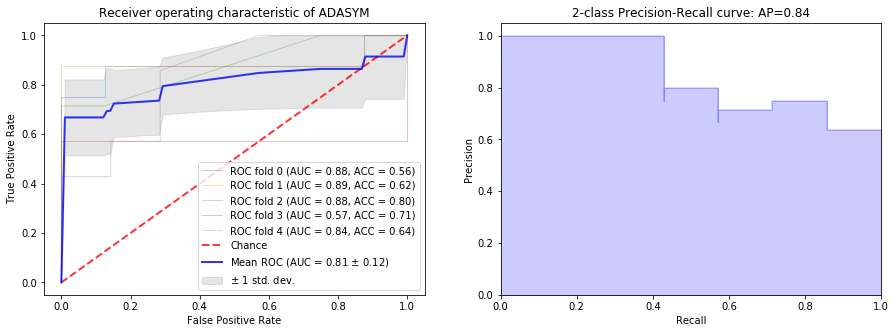

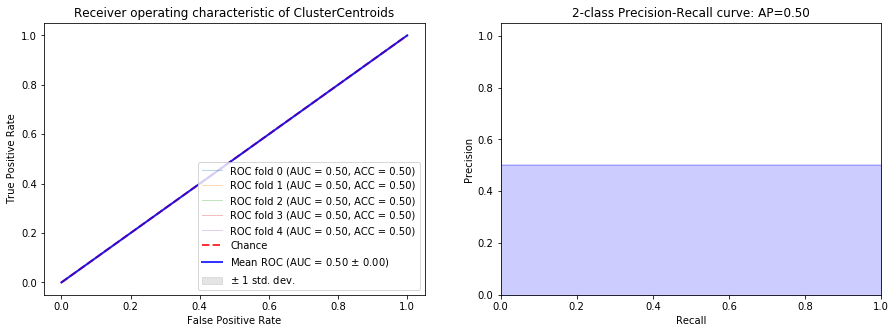

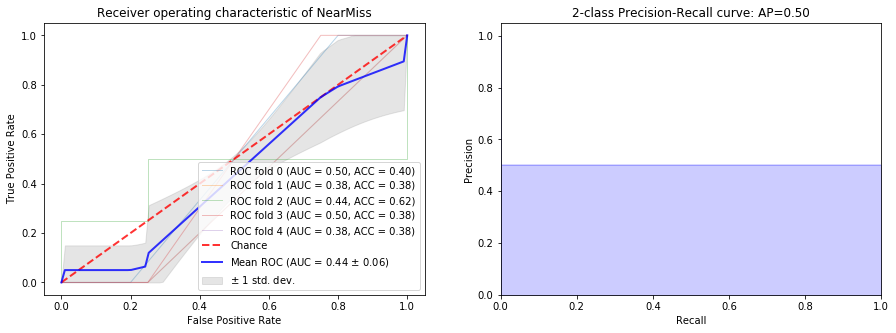

In [9]:
auc_ori = compute_roc(X, y, title='original')

res_X, res_y = SMOTE(ratio = 1.0).fit_sample(X, y)
auc_sm = compute_roc(res_X, res_y, title='SMOTE')

res_X, res_y = ADASYN(ratio = 1.0).fit_sample(X, y)
auc_ada = compute_roc(res_X, res_y, title='ADASYM')

res_X, res_y = ClusterCentroids(random_state=0).fit_sample(X, y)
auc_cc = compute_roc(res_X, res_y, title='ClusterCentroids')

res_X, res_y = NearMiss(random_state=0).fit_sample(X, y)
auc_nm = compute_roc(res_X, res_y, title='NearMiss')
